# 实战 Kaggle 比赛：房价预测


作为深度学习基础篇章的总结，我们将对本章内容学以致用。下面，让我们动手实战一个 Kaggle 比赛：房价预测。

在这个房价预测比赛中，我们还将以 `pandas` 为工具，介绍如何对真实世界中的数据进行重要的预处理，例如：

* 处理离散数据；
* 处理丢失的数据特征；
* 对数据进行标准化。

需要注意的是，本节中对于数据的预处理、模型的设计和超参数的选择等，我们特意只提供最基础的版本。我们希望大家通过动手实战、仔细观察实验现象、认真分析实验结果并不断调整方法，从而得到令自己满意的结果。



## Kaggle 比赛

Kaggle（网站地址：https://www.kaggle.com ）是一个著名的供机器学习爱好者交流的平台。图 3.7 展示了 Kaggle 网站首页。为了便于提交结果，请大家注册 Kaggle 账号。

![Kaggle 网站首页。](../img/kaggle.png)

我们可以在房价预测比赛的网页上了解比赛信息和参赛者成绩、下载数据集并提交自己的预测结果。该比赛的网页地址是

> https://www.kaggle.com/c/house-prices-advanced-regression-techniques


图 3.8 展示了房价预测比赛的网页信息。

![ 房价预测比赛的网页信息。比赛数据集可通过点击“Data”标签获取。](../img/house_pricing.png)



## 获取和读取数据集

比赛数据分为训练数据集和测试数据集。两个数据集都包括每栋房子的特征，例如街道类型、建造年份、房顶类型、地下室状况等特征值。这些特征值有连续的数字、离散的标签甚至是缺失值“na”。只有训练数据集包括了每栋房子的价格。我们可以访问比赛网页，点击图 3.8 中的“Data”标签，并下载这些数据集。

下面，我们通过使用 `pandas` 读入数据。请确保已安装 `pandas` ( 命令行执行 `pip install pandas`)。

In [1]:
import sys
sys.path.append('..')
import gluonbook as gb
from mxnet import autograd, init, gluon, nd
from mxnet.gluon import data as gdata, loss as gloss, nn
import numpy as np
import pandas as pd

train_data = pd.read_csv('../data/kaggle_house_pred_train.csv')
test_data = pd.read_csv('../data/kaggle_house_pred_test.csv')
all_features = pd.concat((train_data.loc[:, 'MSSubClass':'SaleCondition'],
                          test_data.loc[:, 'MSSubClass':'SaleCondition']))

训练数据集包括 1460 个样本、80 个特征和 1 个标签。

In [2]:
train_data.shape

(1460, 81)

测试数据集包括 1459 个样本和 80 个特征。我们需要预测测试数据集上每个样本的标签。

In [3]:
test_data.shape

(1459, 80)

## 预处理数据

我们对连续数值的特征做标准化处理。如果一个特征的值是连续的，设该特征在训练数据集和测试数据集上的均值为 $\mu$，标准差为 $\sigma$。那么，我们可以将该特征的每个值先减去 $\mu$ 再除以 $\sigma$ 得到标准化后的每个特征值。

In [4]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))

现在，我们对离散数值的特征进一步处理，并把缺失数据值用本特征的平均值进行估计。

In [5]:
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features = all_features.fillna(all_features.mean())

接下来，我们把数据转换一下格式。

In [6]:
n_train = train_data.shape[0]
train_features = all_features[:n_train].values
test_features = all_features[n_train:].values
train_labels = train_data.SalePrice.values

## 导入 NDArray 格式数据

为了便于和 ``Gluon`` 交互，我们将数据以 NDArray 的格式导入。

In [7]:
train_features = nd.array(train_features)
train_labels = nd.array(train_labels)
train_labels.reshape((n_train, 1))
test_features = nd.array(test_features)

我们使用平方损失函数训练模型，并定义比赛用来评价模型的函数。

In [8]:
loss = gloss.L2Loss()
def get_rmse_log(net, train_features, train_labels):
    clipped_preds = nd.clip(net(train_features), 1, float('inf'))
    return nd.sqrt(2 * loss(clipped_preds.log(),
                            train_labels.log()).mean()).asnumpy()

## 定义模型

我们将模型的定义放在一个函数里供多次调用。在此我们使用一个基本的线性回归模型，并对模型参数做 Xavier 随机初始化。

In [9]:
def get_net():
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize(init=init.Xavier())
    return net

## 定义训练函数

下面定义模型的训练函数。和本章中前几节不同，这里使用了 Adam 优化算法。我们将在之后的“优化算法”一章里详细介绍它。

In [10]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, verbose_epoch, learning_rate, weight_decay, batch_size):
    train_ls = []
    if test_features is not None:
        test_ls = []
    train_iter = gdata.DataLoader(gdata.ArrayDataset(
        train_features, train_labels), batch_size, shuffle=True)
    # 这里使用了 Adam 优化算法。
    trainer = gluon.Trainer(net.collect_params(), 'adam', {
        'learning_rate': learning_rate, 'wd': weight_decay})
    net.initialize(init=init.Xavier(), force_reinit=True)
    for epoch in range(1, num_epochs + 1):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
            cur_train_l = get_rmse_log(net, train_features, train_labels)
        if epoch >= verbose_epoch:
            print('epoch %d, train loss: %f' % (epoch, cur_train_l))
        train_ls.append(cur_train_l)
        if test_features is not None:    
            cur_test_l = get_rmse_log(net, test_features, test_labels)
            test_ls.append(cur_test_l)
    if test_features is not None:
        gb.semilogy(range(1, num_epochs+1), train_ls, 'epochs', 'loss',
                    range(1, num_epochs+1), test_ls, ['train', 'test'])
    else:
        gb.semilogy(range(1, num_epochs+1), train_ls, 'epochs', 'loss')
    if test_features is not None:
        return cur_train_l, cur_test_l
    else:
        return cur_train_l

## 定义 $K$ 折交叉验证

我们在 [“欠拟合、过拟合和模型选择”](underfit-overfit.md) 一节中介绍了 $K$ 折交叉验证。下面，我们将定义 $K$ 折交叉验证函数，并根据 $K$ 折交叉验证的结果选择模型设计并调参。

In [11]:
def k_fold_cross_valid(k, epochs, verbose_epoch, X_train, y_train,
                       learning_rate, weight_decay, batch_size):
    assert k > 1
    fold_size = X_train.shape[0] // k
    train_l_sum = 0.0
    test_l_sum = 0.0
    for test_i in range(k):
        X_val_test = X_train[test_i * fold_size: (test_i + 1) * fold_size, :]
        y_val_test = y_train[test_i * fold_size: (test_i + 1) * fold_size]
        val_train_defined = False
        for i in range(k):
            if i != test_i:
                X_cur_fold = X_train[i * fold_size: (i + 1) * fold_size, :]
                y_cur_fold = y_train[i * fold_size: (i + 1) * fold_size]
                if not val_train_defined:
                    X_val_train = X_cur_fold
                    y_val_train = y_cur_fold
                    val_train_defined = True
                else:
                    X_val_train = nd.concat(X_val_train, X_cur_fold, dim=0)
                    y_val_train = nd.concat(y_val_train, y_cur_fold, dim=0)
        net = get_net()
        train_l, test_l = train(
            net, X_val_train, y_val_train, X_val_test, y_val_test, 
            epochs, verbose_epoch, learning_rate, weight_decay, batch_size)
        train_l_sum += train_l
        print('test loss: %f' % test_l)
        test_l_sum += test_l
    return train_l_sum / k, test_l_sum / k

## 交叉验证模型

现在，我们可以交叉验证模型了。以下的超参数都是可以调节的。

epoch 98, train loss: 0.169971
epoch 99, train loss: 0.170017
epoch 100, train loss: 0.169969


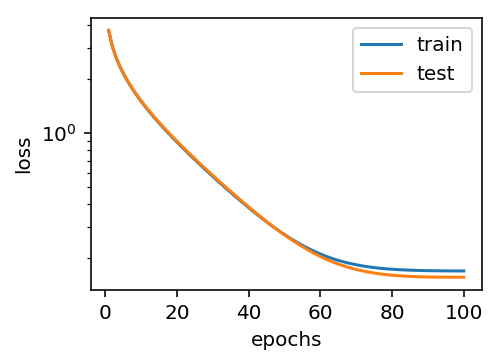

test loss: 0.156815


epoch 98, train loss: 0.162430
epoch 99, train loss: 0.162270
epoch 100, train loss: 0.162089


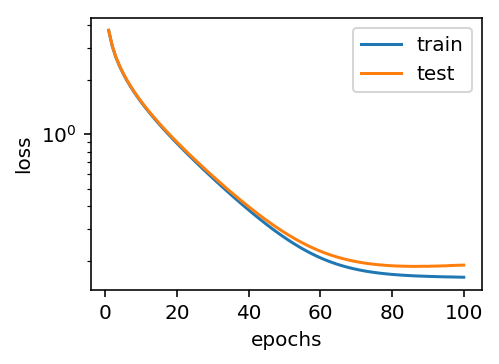

test loss: 0.189119


epoch 98, train loss: 0.163969
epoch 99, train loss: 0.163726
epoch 100, train loss: 0.163644


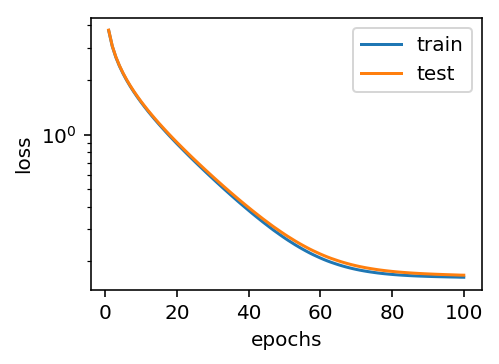

test loss: 0.167979


epoch 98, train loss: 0.167964
epoch 99, train loss: 0.167910
epoch 100, train loss: 0.167774


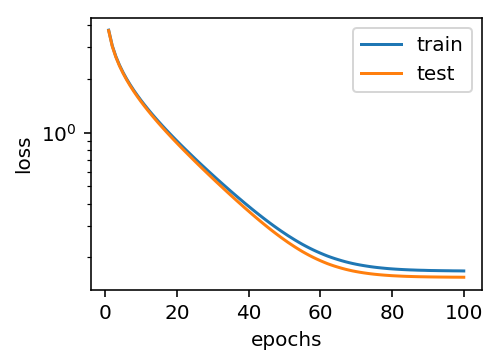

test loss: 0.154693


epoch 98, train loss: 0.162771
epoch 99, train loss: 0.162742
epoch 100, train loss: 0.162764


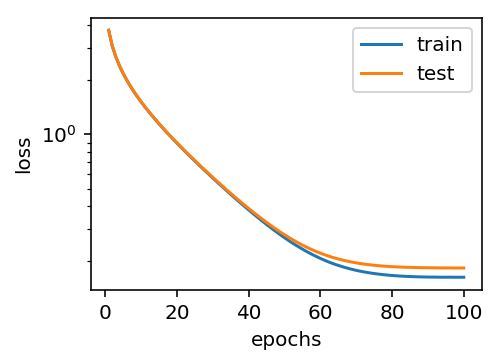

test loss: 0.182991
5-fold validation: avg train loss: 0.165248, avg test loss: 0.170319


In [12]:
k = 5
num_epochs = 100
verbose_epoch = num_epochs - 2
lr = 5
weight_decay = 0
batch_size = 64

train_l, test_l = k_fold_cross_valid(k, num_epochs, verbose_epoch,
                                     train_features, train_labels, lr,
                                     weight_decay, batch_size)
print('%d-fold validation: avg train loss: %f, avg test loss: %f'
      % (k, train_l, test_l))

在设定了一组参数后，即便训练误差可以达到很低，但是在 $K$ 折交叉验证上的误差可能反而较高。这种现象这很可能是由于过拟合造成的。因此，当训练误差特别低时，我们要观察 $K$ 折交叉验证上的误差是否同时降低，以避免模型的过拟合。


## 预测并在 Kaggle 提交结果

我们首先定义预测函数。在预测之前，我们会使用完整的训练数据集来重新训练模型。

In [13]:
def train_and_pred(num_epochs, verbose_epoch, train_features, test_feature,
                   train_labels, test_data, lr, weight_decay, batch_size):
    net = get_net()
    train(net, train_features, train_labels, None, None, num_epochs,
          verbose_epoch, lr, weight_decay, batch_size)
    preds = net(test_features).asnumpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

设计好模型并调好超参数之后，下一步就是对测试数据集上的房屋样本做价格预测，并在 Kaggle 上提交结果。

epoch 98, train loss: 0.162941
epoch 99, train loss: 0.162649
epoch 100, train loss: 0.162353


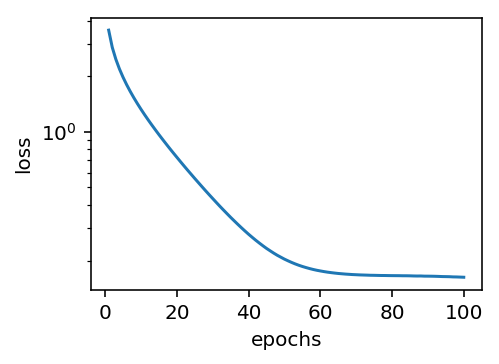

In [14]:
train_and_pred(num_epochs, verbose_epoch, train_features, test_features,
               train_labels, test_data, lr, weight_decay, batch_size)

上述代码执行完之后会生成一个“submission.csv”文件。这个文件是符合 Kaggle 比赛要求的提交格式的。这时，我们可以在 Kaggle 上把我们预测得出的结果进行提交，并且查看与测试数据集上真实房价（标签）的误差。具体来说有以下几个步骤：你需要登录 Kaggle 网站，访问房价预测比赛网页，并点击右侧“Submit Predictions”或“Late Submission”按钮。然后，点击页面下方“Upload Submission File”选择需要提交的预测结果文件。最后，点击页面最下方的“Make Submission”按钮就可以查看结果了。如图 3.9 所示。

![Kaggle 预测房价比赛的预测结果提交页面。](../img/kaggle_submit2.png)


## 小结

* 我们通常需要对真实数据做预处理。
* 我们可以使用 $K$ 折交叉验证来选择模型并调参。


## 练习

* 在 Kaggle 提交本教程的预测结果。观察一下，这个结果能在 Kaggle 上拿到什么样的分数？
* 对照 $K$ 折交叉验证结果，不断修改模型（例如添加隐藏层）和调参，你能提高 Kaggle 上的分数吗？
* 如果不使用本节中对连续数值特征的标准化处理，结果会有什么变化 ?
* 扫码直达讨论区，在社区交流方法和结果。你能发掘出其他更好的技巧吗？


## 扫码直达 [ 讨论区 ](https://discuss.gluon.ai/t/topic/1039)

![](../img/qr_kaggle-house-price.svg)